In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelBinarizer, TargetEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from tabulate import tabulate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [89]:
# Percorso del file
file_path = 'KDDTrainClean.csv'

# Carico il dataset in un DataFrame
df = pd.read_csv(file_path)
print("Dataset caricato con successo.")
print(f"Dimensioni del dataset: {df.shape}")

# Split label in y
X = df.drop('label', axis=1)
y = df['label']

# Trasformazione della variabile target in binaria
y_binary = (y != "normal").astype(int)
y_binary = pd.Series(y_binary)
# Visualizzo le prime righe del dataset
df.head()


Dataset caricato con successo.
Dimensioni del dataset: (125973, 42)


duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17                    0.03   
1                    0.00                    0.60   
2                    0.10                    0.05   
3                    1.00                    0.00   
4                    1.00                    0.00   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                         0.17                         0.00   
1                         0.88                         0.00   
2                         0.00                         0.00   
3                         0.03                         0.04   
4                         0.00                         0.00   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                  0.00                      0.00                  0.05   
1                  0.00                      0.00                  0.00   
2                  1.00                      1.00                  0.00   
3                  0.03                      0.01                  0.00   
4                  0.00                      0.00                  0.00   

   dst_host_srv_rerror_rate    label  
0                      0.00   normal  
1                      0.00   normal  
2                      0.00  neptune  
3                      0.01   normal  
4                      0.00   normal  

[5 rows x 42 columns]

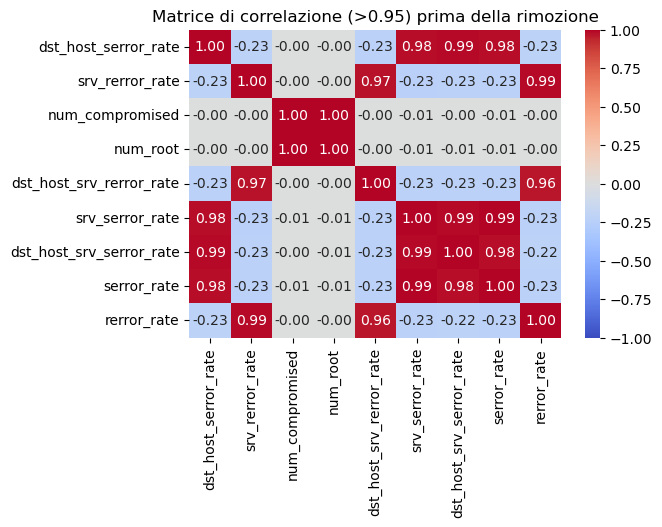

Coppie di colonne altamente correlate in formato tabellare con percentuale di correlazione:


Feature 1                 Feature 2  Correlation Index
0       num_compromised                  num_root          99.883345
1           serror_rate           srv_serror_rate          99.328924
2           serror_rate      dst_host_serror_rate          97.937308
3           serror_rate  dst_host_srv_serror_rate          98.113896
4       srv_serror_rate      dst_host_serror_rate          97.759601
5       srv_serror_rate  dst_host_srv_serror_rate          98.625172
6           rerror_rate           srv_rerror_rate          98.900765
7           rerror_rate  dst_host_srv_rerror_rate          96.444867
8       srv_rerror_rate  dst_host_srv_rerror_rate          97.020800
9  dst_host_serror_rate  dst_host_srv_serror_rate          98.505222

In [91]:
# Calcolo della matrice di correlazione (prima della rimozione)
correlation_matrix = X.corr(numeric_only=True)
highly_correlated_pairs = []
threshold = 0.95

for i in range(correlation_matrix.shape[0]):
    for j in range(i + 1, correlation_matrix.shape[1]):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            highly_correlated_pairs.append((
                correlation_matrix.index[i], 
                correlation_matrix.columns[j], 
                correlation_matrix.iloc[i, j]
            ))

# Visualizzo le coppie altamente correlate in un grafico
plt.figure(figsize=(6, 4))
correlated_features = list(set([item for sublist in highly_correlated_pairs for item in sublist[:2]]))
correlation_matrix_filtered = correlation_matrix.loc[correlated_features, correlated_features]
sns.heatmap(correlation_matrix_filtered, cmap='coolwarm', annot=True, fmt='.2f', vmin=-1, vmax=1)
plt.title("Matrice di correlazione (>0.95) prima della rimozione")
plt.show()

# Visualizzazione delle coppie altamente correlate in formato tabellare
correlated_df = pd.DataFrame(highly_correlated_pairs, columns=['Feature 1', 'Feature 2', 'Correlation Index'])
correlated_df['Correlation Index'] = correlated_df['Correlation Index'].abs() * 100  # Converto in percentuale
print("Coppie di colonne altamente correlate in formato tabellare con percentuale di correlazione:")
correlated_df.head(10)


In [93]:
# Rimuovere le feature costanti
constant_columns = [col for col in X.columns if X[col].nunique() == 1]
X = X.drop(columns=constant_columns)

# Itera fino a quando non ci sono più feature altamente correlate
while True:
    correlation_matrix = X.corr(numeric_only=True)
    highly_correlated_pairs = []

    # Identifica le coppie di feature altamente correlate
    for i in range(correlation_matrix.shape[0]):
        for j in range(i + 1, correlation_matrix.shape[1]):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                highly_correlated_pairs.append((
                    correlation_matrix.index[i], 
                    correlation_matrix.columns[j], 
                    correlation_matrix.iloc[i, j]
                ))

    # Se non ci sono più coppie sopra la soglia, interrompi il ciclo
    if not highly_correlated_pairs:
        break

    # Determina le feature da rimuovere
    features_to_remove = []
    visited = set()
    
    for feature1, feature2, _ in highly_correlated_pairs:
        if feature1 not in visited and feature2 not in visited:
            # Confronta la correlazione con il target
            corr_feature1 = X[feature1].corr(y_binary)
            corr_feature2 = X[feature2].corr(y_binary)

            # Rimuove la feature con correlazione minore in valore assoluto
            if abs(corr_feature1) >= abs(corr_feature2):
                features_to_remove.append(feature2)
            else:
                features_to_remove.append(feature1)

            visited.add(feature1)
            visited.add(feature2)

    X = X.drop(columns=features_to_remove)
    print("Feature rimosse per alta correlazione:", features_to_remove)

print("Numero di feature rimanenti: ",len(X.columns))

Feature rimosse per alta correlazione: ['num_compromised', 'srv_serror_rate', 'rerror_rate', 'dst_host_serror_rate']
Feature rimosse per alta correlazione: ['serror_rate', 'dst_host_srv_rerror_rate']
Numero di feature rimanenti:  34


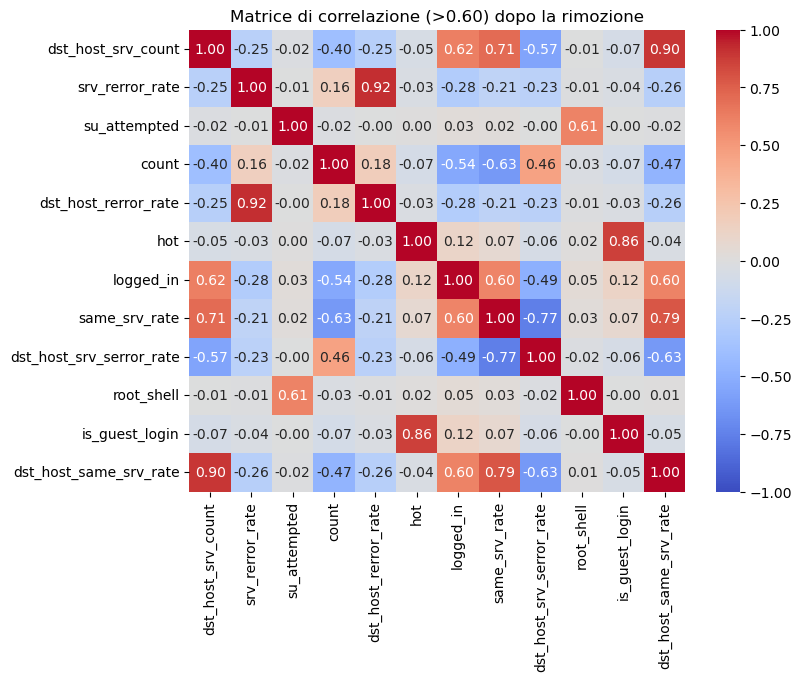

In [95]:
# Calcolo della matrice di correlazione (dopo la rimozione) con soglia 0.60
correlation_matrix = X.corr(numeric_only=True)
highly_correlated_pairs = []
threshold = 0.60

for i in range(correlation_matrix.shape[0]):
    for j in range(i + 1, correlation_matrix.shape[1]):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            highly_correlated_pairs.append((
                correlation_matrix.index[i], 
                correlation_matrix.columns[j], 
                correlation_matrix.iloc[i, j]
            ))

# Visualizzo le coppie altamente correlate in un grafico
plt.figure(figsize=(8, 6))
correlated_features = list(set([item for sublist in highly_correlated_pairs for item in sublist[:2]]))
correlation_matrix_filtered = correlation_matrix.loc[correlated_features, correlated_features]
sns.heatmap(correlation_matrix_filtered, cmap='coolwarm', annot=True, fmt='.2f', vmin=-1, vmax=1)
plt.title("Matrice di correlazione (>0.60) dopo la rimozione")
plt.show()

In [97]:
results_dictionary={}
def metrics_score(y_true, y_pred):
    metrics = {}
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)
    metrics['Precision'] = precision_score(y_true, y_pred, average='weighted')
    metrics['Recall'] = recall_score(y_true, y_pred, average='weighted')
    metrics['F1-Score'] = f1_score(y_true, y_pred, average='weighted')
    return metrics

In [99]:
n_iterations = 10  # Numero di shuffle

# Identificare i tipi di feature
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

# Rimuovere "service" dalle feature categoriche per applicare Target Encoding
categorical_features.remove("service")
best_params_knn= {'weights': 'distance', 'n_neighbors': 4, 'metric': 'manhattan'}
acc=[]
prec=[]
rec=[]
f1=[]
np.random.seed(42)  # Seed fisso per riproducibilità della generazione di seed casuali
random_seeds = np.random.randint(0, 10000, size=n_iterations)  # Genera n_iterations seed unici
for i, seed in enumerate(random_seeds):
    print(seed)
    # Suddivisione iniziale: 80% training+validation, 20% test
    X_temp, X_test, y_temp, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=seed)
    
    # Suddivisione del training+validation in 75% training, 25% validation
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=seed)
    
    scaler = MinMaxScaler()
    X_train_n = scaler.fit_transform(X_train[numeric_features])
    X_val_n = scaler.transform(X_val[numeric_features])
    X_test_n = scaler.transform(X_test[numeric_features])
    
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    X_train_e = encoder.fit_transform(X_train[categorical_features])
    X_val_e = encoder.transform(X_val[categorical_features])
    X_test_e = encoder.transform(X_test[categorical_features])
    
    target_encoder = TargetEncoder()
    X_train_te = target_encoder.fit_transform(X_train[["service"]], y_train)
    X_val_te = target_encoder.transform(X_val[["service"]])
    X_test_te = target_encoder.transform(X_test[["service"]])
    
    X_train_final = np.hstack([X_train_n, X_train_e, X_train_te])
    X_val_final = np.hstack([X_val_n, X_val_e, X_val_te])
    X_test_final = np.hstack([X_test_n, X_test_e, X_test_te])
    
    X_train_final_ = pd.DataFrame(X_train_final)
                 
    X_train_knn, X_val_knn, X_test_knn = X_train_final , X_val_final , X_test_final
   
    # Addestrare il modello con i migliori parametri
    fitted_knn = KNeighborsClassifier(**best_params_knn).fit(X_train_knn, y_train)
    
    # Predizione sul validation set
    y_pred_knn = fitted_knn.predict(X_val_knn)
    
    metrics_knn = metrics_score(y_val, y_pred_knn)
    results_dictionary["K-Nearest Neighbors"] = metrics_knn
    print("Model fit done: Metrics saved in results_dictionary !")
    acc.append(metrics_knn["Accuracy"])
    prec.append(metrics_knn["Precision"])
    rec.append(metrics_knn["Recall"])
    f1.append(metrics_knn["F1-Score"])
    
    table_knn = [["Accuracy", metrics_knn["Accuracy"]],
             ["Precision", metrics_knn["Precision"]],
             ["Recall", metrics_knn["Recall"]],
             ["F1-Score", metrics_knn["F1-Score"]]]
    
    print("    K-Nearest Neighbors")
    print(tabulate(table_knn, headers=["Metric", "Value"], tablefmt="grid", colalign=("center", "center")))


7270
Model fit done: Metrics saved in results_dictionary !
    K-Nearest Neighbors
+-----------+----------+
|  Metric   |  Value   |
+===========+==========+
| Accuracy  | 0.995872 |
+-----------+----------+
| Precision | 0.995874 |
+-----------+----------+
|  Recall   | 0.995872 |
+-----------+----------+
| F1-Score  | 0.995872 |
+-----------+----------+
860
Model fit done: Metrics saved in results_dictionary !
    K-Nearest Neighbors
+-----------+----------+
|  Metric   |  Value   |
+===========+==========+
| Accuracy  | 0.996031 |
+-----------+----------+
| Precision | 0.996031 |
+-----------+----------+
|  Recall   | 0.996031 |
+-----------+----------+
| F1-Score  | 0.996031 |
+-----------+----------+
5390
Model fit done: Metrics saved in results_dictionary !
    K-Nearest Neighbors
+-----------+----------+
|  Metric   |  Value   |
+===========+==========+
| Accuracy  | 0.996468 |
+-----------+----------+
| Precision | 0.996468 |
+-----------+----------+
|  Recall   | 0.996468 |
+-

# Stampiamo la media e la deviazione standard dei risultati dei 10 tentativi

In [102]:
mean_acc = np.mean(acc)
std_acc = np.std(acc)

mean_prec = np.mean(prec)
std_prec = np.std(prec)

mean_rec = np.mean(rec)
std_rec = np.std(rec)

mean_f1 = np.mean(f1)
std_f1 = np.std(f1)

table_knn = [["Accuracy", mean_acc,std_acc],
             ["Precision", mean_prec,std_prec],
             ["Recall", mean_rec,std_rec],
             ["F1-Score",mean_f1,std_f1]]
print("          K-Nearest Neighbors")
print(tabulate(table_knn, headers=[" Metric", "Mean","Std Dev  "], tablefmt="grid", colalign=("center", "center")))

          K-Nearest Neighbors
+-----------+----------+-------------+
|   Metric  |   Mean   |   Std Dev   |
+===========+==========+=============+
| Accuracy  | 0.996321 | 0.000263904 |
+-----------+----------+-------------+
| Precision | 0.996321 | 0.000263761 |
+-----------+----------+-------------+
|  Recall   | 0.996321 | 0.000263904 |
+-----------+----------+-------------+
| F1-Score  | 0.996321 | 0.000263942 |
+-----------+----------+-------------+
